In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import graph_tool as gt
import matplotlib
matplotlib.use('Agg')

from graph_tool import Graph, GraphView
from graph_tool.topology import random_spanning_tree
from graph_tool.generation import complete_graph, lattice
from graph_tool.draw import sfdp_layout, graph_draw
from matplotlib import pyplot as plt
from scipy.stats import entropy

from tqdm import tqdm

from cascade_generator import si, observe_cascade
from graph_helpers import (extract_steiner_tree, filter_graph_by_edges, extract_edges,
                           extract_nodes, gen_random_spanning_tree, load_graph_by_name)
from viz_helpers import lattice_node_pos

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
random.seed(1234)
np.random.seed(1234)
shape = (10, 10)
graph_name = 'lattice'
g = load_graph_by_name(graph_name)


In [4]:
if graph_name == 'lattice':
    pos = lattice_node_pos(g, shape)
else:
    pos = sfdp_layout(g)


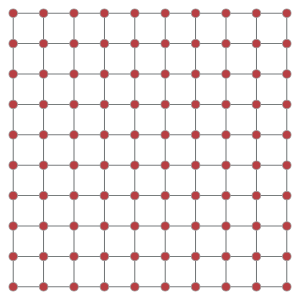

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9df69a3fd0, at 0x7f9df69a3d30>

In [5]:
graph_draw(g, pos=pos, output_size=(300, 300))    

In [6]:
s, c, t = si(g, 0.1)
o = observe_cascade(c, s, 0.2)
print(o)

[79 64 96 84 27 89 38 29 77 68 25]


In [20]:
t.set_directed(False)

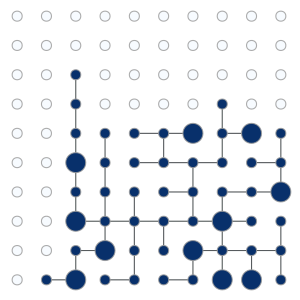

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9df69a3fd0, at 0x7f9df69a3d30>

In [21]:
vsize = t.new_vertex_property('int')
vsize.set_value(10)
for i in o:
    vsize[i] = 20
vcolor = t.new_vertex_property('float')    
vcolor.set_value(0)
vcolor.a[(c>-1).nonzero()[0]] = 1
graph_draw(t, pos=pos, vertex_size=vsize, vertex_fill_color=vcolor, output_size=(300, 300),
           vcmap=matplotlib.cm.Blues)

In [22]:
from core import uncertainty_scores, sample_steiner_trees, node_occurrence_freq
st_trees = sample_steiner_trees(g, o, 500)

uc = uncertainty_scores(g, o, st_trees, 500, 100, method='count', use_resample=True)

inf_probas = np.array([node_occurrence_freq(n, st_trees)[0] for n in extract_nodes(g)]) / len(st_trees)

In [25]:
plt.switch_backend('cairo')

fig = plt.figure(figsize=(15, 7.5))
ax = fig.add_subplot(1, 2, 1)

node_max_size=25

vsize = g.new_vertex_property('int')
vsize.set_value(node_max_size)

vcolor = g.new_vertex_property('float')
vcolor.set_value(0)
for n, uncert in uc.items():
    vcolor[n] = uncert

vsize = g.new_vertex_property('int')
vsize.set_value(node_max_size)

uncerts = np.array(list(uc.values()))

for n, uncert in uc.items():
    vsize[n] = uncert / uncerts.max() * node_max_size
    
graph_draw(g, pos=pos, vertex_size=vsize,
           vertex_fill_color=vcolor, vcmap=matplotlib.cm.Blues,
           mplfig=ax)
ax.set_title('uncertainty')
           # output='figs/concept-proof-count.pdf')

#############

ax = fig.add_subplot(1, 2, 2)

vcolor = g.new_vertex_property('float')
vcolor.set_value(0)

vcolor.a = inf_probas
for n in o:
    vcolor[n] = 0
    
vsize = g.new_vertex_property('float')    
vsize.set_value(node_max_size)

missing_node_probas = np.array([inf_probas[n] for n in extract_nodes(g) if n not in o])
max_val = missing_node_probas.max()
for n in extract_nodes(g):
    if n not in o:
        vsize[n] = inf_probas[n] / max_val * node_max_size

    
graph_draw(g, pos=pos, vertex_size=vsize, vertex_fill_color=vcolor,
           vcmap=matplotlib.cm.Blues,
           mplfig=ax)
ax.set_title('infection probability')
           # output='figs/predicted-infection.pdf')
    
fig.savefig('figs/inf-proba-vs-uncertainty.png')    

In [24]:
fig = plt.figure(figsize=(15, 10))


ax = fig.add_subplot(1, 2, 1)

vcolor = g.new_vertex_property('float')
vcolor.set_value(0)
inf_nodes = (c>=0).nonzero()[0]
vcolor.a[inf_nodes] = 1
graph_draw(g, pos=pos, vertex_size=20, vertex_fill_color=vcolor,
           vcmap=matplotlib.cm.Reds,
           mplfig=ax)
ax.set_title('actual infection')


ax = fig.add_subplot(1, 2, 2)

vcolor = g.new_vertex_property('float')
vcolor.set_value(0)
inf_nodes = (inf_probas>=0.5).nonzero()[0]
vcolor.a[inf_nodes] = 1
graph_draw(g, pos=pos, output_size=(300, 300), vertex_size=20, vertex_fill_color=vcolor,
           vcmap=matplotlib.cm.Reds,
           mplfig=ax)
ax.set_title('predicted infection (p>=0.5)')

fig.savefig('figs/actual-infection-vs-prediction.pdf')